### <center> <h2>  IBOAT RL Tutorial - Stall avoidance </h2> </center>

### Intro :
<div class="alert alert-success" style="margin-top: 1em">


Going through this notebook is the best way to get familiar with the scripts of the repository: https://github.com/tristan-ka/IBOAT_RL. 

The tutorial starts slowly by explaining how to run simulations that respsect the Markov Decision Process formalism. We later present how to train models to learn sailing behaviors. If you believe that this tutorial lacks clarity you can refer to the documentation of the classes used here on the following page: https://tristan-ka.github.io/IBOAT_RL/
</div>

#### Table des matières

1. MDP simulation using the simplified simulator
2. MDP simulation using the realistic simulator
3. Training a DQN agent on the simplified simulator
    - Training
    - Visualizing results
4. Training a DDDP agent on the simplified simulator

We start by loading the modules that we need for the whole notebook

In [8]:
import sys
sys.path.append("../sim/")
sys.path.append("../RL/")

from matplotlib import pyplot as plt
import numpy as np
import math
import random
%matplotlib inline
import tensorflow as tf

from DDPG import DDPGAgent
import mdp
from Simulator import TORAD
from environment import wind

TORAD = math.pi / 180

### 1. MDP simulation using the simplified simulator

A simulator of a simplified dynamic of the boat is provided by class **Simulator** in module **Simulator** and class **Hysteresis** in module **hysteresis**.
In order to operate state transitions, these models are gathered in class **mdp.MDP** where an agent interacting with the simplified environment is implemented.

The following code shows how to easily get a simulation with state transitions and plot it. A simple behaviour is represented in this example: we alternate 2 periods of bear-off command and 2 periods of luff command on rudder.

The first step consists of defining the paramaters of our MDP model and initializin it.

In [9]:
history_duration = 3
mdp_step = 1
time_step = 0.1
SP = -40 * TORAD
mdp = mdp.MDP(history_duration, mdp_step, time_step)

mean = 45 * TORAD
std = 0 * TORAD
wind_samples = 10
WH = np.random.uniform(mean - std, mean + std, size=10)

hdg0 = 0 * TORAD * np.ones(wind_samples)
state = mdp.initializeMDP(hdg0, WH)

SIMULATION_TIME = 100

Then we use a loop to simulate time and use the method ```mdp.transition()``` with the action correponding to the behavior we discussed previously.

In [10]:
i = np.ones(0)
vmg = np.ones(0)
wind_heading = np.ones(0)

# We simulate a simple behaviour which alternates periods of bear-off and luff commands
for time in range(SIMULATION_TIME):
#     print('t = {0} s'.format(time))
    action = 0
    WH = np.random.uniform(mean - std, mean + std, size=wind_samples)
    if time < SIMULATION_TIME / 4:
        action = 0
    elif time < SIMULATION_TIME / 2:
        action = 1
    elif time < 3 * SIMULATION_TIME / 4:
        action = 0
    else:
        action = 1

    next_state, reward = mdp.transition(action, WH)
    next_state = state
    i = np.concatenate([i, mdp.extractSimulationData()[0, :]])
    vmg = np.concatenate([vmg, mdp.extractSimulationData()[1, :]])
    wind_heading = np.concatenate([wind_heading, WH])

time_vec = np.linspace(0, SIMULATION_TIME, int((SIMULATION_TIME) / time_step))
hdg = i - wind_heading - SP

v = vmg / np.cos(0 - hdg)

At the end of the simulation we can plot the simulation :

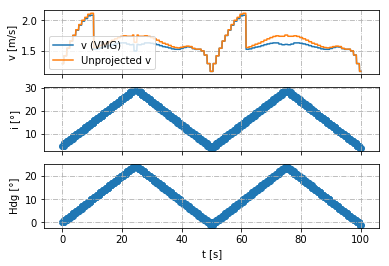

In [11]:
# %%
f, axarr = plt.subplots(3, sharex=True)
vmg_plot = axarr[0].plot(time_vec, vmg, label="v (VMG)")
v_plot = axarr[0].plot(time_vec, v, label="Unprojected v")
axarr[0].legend()
axarr[0].set_ylabel("v [m/s]")

i_plot = axarr[1].scatter(time_vec, i / TORAD, label='i [°]')
axarr[1].set_ylabel("i [°]")
hdg_plot = axarr[2].scatter(time_vec, hdg / TORAD, label='Hdg [°]')
axarr[2].set_ylabel("Hdg [°]")
plt.xlabel("t [s]")

axarr[0].grid(True)
gridlines = axarr[0].get_xgridlines() + axarr[0].get_ygridlines()
for line in gridlines:
    line.set_linestyle('-.')

axarr[1].grid(True)
gridlines = axarr[1].get_xgridlines() + axarr[1].get_ygridlines()
for line in gridlines:
    line.set_linestyle('-.')

axarr[2].grid(True)
gridlines = axarr[2].get_xgridlines() + axarr[2].get_ygridlines()
for line in gridlines:
    line.set_linestyle('-.')

**NB:** This class enables the agent to take two possible actions as commands:
- Bear-off: growing rudder angle by +1° (when action = 0)
- Luff: dropping rudder angle by -1° (when action = 1)

In order to model more relevant sailing command a class **mdp.ContinuousMDP** has been implemented. More specifically, it will use for continuous control learning with DDPG in part 4.

### 2. MDP simulation using the realistic simulator

### 3. Training a DQN agent on the simplified simulator

#### Training

#### Visualizing results

### 4. Training a DDPG agent on the simplified simulator

Deep Deterministic Policy Gradient method is implemented in class **DDPG.DDPGAgent**. It uses indirectly 2 modules:
- **DDPGNetworks**: tensorflow session implementation of the Actor-Critic model
- **DDPGModel**: tensorflow model building of both actor and critic CNN weights

The following script suggests training a DDPGAgent on simplified simulator with possibility of getting loss of both networks and critic prediction along learning. Settings of the model are given as argument of DDPGAgent constructor. For more specific settings (and especially exploration noise quantifying), please see the inner constructor of DDPAgent. To set the networks lay-outs, see functions **DDPGModel.build_actor** and **DDPGModel.build_critic**.

**NB**: 
- Gaussian wind conditions can be modeled as desired by setting mean and standard deviation parameters in class **environment.wind**
- This script can be easily adapted to Realistic Simulator by changing class of the chosen MDP.

The **DDPG** algorithm works with **continuous** actions. We therefore load the corresponding module :

In [12]:
from mdp import ContinuousMDP

We then define the training parameter and initialize the learning scenario :

In [13]:
'''
MDP Parameters
'''
history_duration = 6  # Duration of state history [s]
mdp_step = 1  # Step between each state transition [s]
time_step = 0.1  # time step [s] <-> 10Hz frequency of data acquisition
lower_bound = -3.0
upper_bound = 3.0
mdp = ContinuousMDP(history_duration, mdp_step, time_step,lower_bound,upper_bound)

'''
WIND CONDITIONS
'''
mean = 45 * TORAD
std = 0 * TORAD
wind_samples = 10
w = wind(mean=mean, std=std, samples = wind_samples)
WH = w.generateWind()


'''
Random initial conditions 
'''
# hdg0_rand_vec=(0,2,4,6,8,10,13,15,17,20)
hdg0_rand_vec=(0,7,13,18)
action_size = 2
action_size_DDPG = 1

'''
Initialize Simulation
'''

batch_size = 32

EPISODES = 5

count_luff=0
count_bear_off=0


Once this is done we can start training the model

NOISY ACTION
the last seen (i,v) is: (0.0, 0.0)
the action is: 0.21110648032200618
the reward is: 0.6729038102241474
NOISY ACTION
the last seen (i,v) is: (23.211106480322009, 1.6144724966012849)
the action is: 2.994562312634642
the reward is: 0.17624510996357612
NOISY ACTION
the last seen (i,v) is: (26.205668792956644, 1.6315040312238809)
the action is: -2.334678434476195
the reward is: 0.17809235223490105
NOISY ACTION
the last seen (i,v) is: (23.870990358480451, 1.6233392595036438)
the action is: -1.1516144311582015
the reward is: 0.17437798226514512
NOISY ACTION
the last seen (i,v) is: (22.719375927322258, 1.6136750553690524)
the action is: 2.7713322398634173
the reward is: 0.17584580252885362
NOISY ACTION
the last seen (i,v) is: (25.490708167185666, 1.6303847967694447)
the action is: -0.589401129369866
the reward is: 0.1794285786848141
NOISY ACTION
the last seen (i,v) is: (24.901307037815801, 1.6308723809176628)
the action is: 0.8484989635923728
the reward is: 0.17930059500832563
NO

Actor network loss: 0.03939270228147507
Critic network loss: 0.15208354592323303
episode: 0/5, Actor Mean Loss = 0.03939270228147507
episode: 0/5, Critic Mean Loss = 0.15208354592323303
NOISY ACTION
the last seen (i,v) is: (0.0, 0.0)
the action is: -2.6125381091685167
the reward is: 0.6406192818875288
NOISY ACTION
the last seen (i,v) is: (15.387461890831487, 1.5245969732745959)
the action is: 1.077373233940211
the reward is: 0.6360665921565645
NOISY ACTION
the last seen (i,v) is: (16.464835124771692, 1.5285226690769134)
the action is: 2.711986938996776
the reward is: 0.644057881547766
NOISY ACTION
the last seen (i,v) is: (19.176822063768466, 1.5629551623523636)
the action is: 0.925425708590268
the reward is: 0.15331494190823858
NOISY ACTION
the last seen (i,v) is: (20.102247772358744, 1.5729565588071814)
the action is: -2.7257207116582767
the reward is: 0.1486921515456553
NOISY ACTION
the last seen (i,v) is: (17.376527060700468, 1.5407657686119636)
the action is: -2.4924722199775244
th

episode: 1/5, Actor Mean Loss = 0.1583227813243866
episode: 1/5, Critic Mean Loss = 0.09969142079353333
NOISY ACTION
the last seen (i,v) is: (0.0, 0.0)
the action is: -1.7190545151246663
the reward is: 0.6681858257294998
NOISY ACTION
the last seen (i,v) is: (21.280945484875335, 1.591826171026977)
the action is: 0.16954042186408103
the reward is: 0.163825084482476
NOISY ACTION
the last seen (i,v) is: (21.450485906739416, 1.5945342344889071)
the action is: 0.6447502632352515
the reward is: 0.16651759130339294
NOISY ACTION
the last seen (i,v) is: (22.095236169974665, 1.6047502037673789)
the action is: -0.535608067867333
the reward is: 0.16688063641409367
NOISY ACTION
the last seen (i,v) is: (21.559628102107336, 1.5962768510202703)
the action is: 1.3488583664758593
the reward is: 0.16917848109932565
NOISY ACTION
the last seen (i,v) is: (22.908486468583195, 1.6157798582564926)
the action is: -0.860962168282585
the reward is: 0.17078783849279144
NOISY ACTION
the last seen (i,v) is: (22.04752

the action is: -0.4128431275893183
the reward is: 0.17731012307559113
NOISY ACTION
the last seen (i,v) is: (24.30803243812549, 1.6232579234762532)
the action is: -0.5919452418891571
the reward is: 0.17585087170775537
NOISY ACTION
the last seen (i,v) is: (23.716087196236334, 1.6208262607209722)
the action is: -2.4741353220778857
the reward is: 0.1691734070583183
NOISY ACTION
the last seen (i,v) is: (21.241951874158445, 1.5912060931589551)
the action is: 2.48602921578871
the reward is: 0.1692137479068765
NOISY ACTION
the last seen (i,v) is: (23.727981089947168, 1.6210198967940519)
the action is: -0.7243382973832784
the reward is: 0.1742643238691004
NOISY ACTION
the last seen (i,v) is: (23.003642792563884, 1.61544885777763)
the action is: -0.45570648753270415
the reward is: 0.17233200647470615
NOISY ACTION
the last seen (i,v) is: (22.547936305031183, 1.6117447733009587)
the action is: 0.7041327786593028
the reward is: 0.17208785983878927
NOISY ACTION
the last seen (i,v) is: (23.2520690836

the reward is: 0.17782150553465015
NOISY ACTION
the last seen (i,v) is: (25.419401536595018, 1.6306651895661297)
the action is: -2.3132787172130596
the reward is: 0.17617389194554056
NOISY ACTION
the last seen (i,v) is: (23.106122819381955, 1.6149694917724653)
the action is: -2.860724697335189
the reward is: 0.16462708833514006
NOISY ACTION
the last seen (i,v) is: (20.245398122046765, 1.5752405322362071)
the action is: 0.8008946625545188
the reward is: 0.15902469571703037
NOISY ACTION
the last seen (i,v) is: (21.046292784601292, 1.5880780072055387)
the action is: 2.043580508424168
the reward is: 0.16731747694061105
NOISY ACTION
the last seen (i,v) is: (23.089873293025459, 1.6150458821093943)
the action is: -2.860937835381807
the reward is: 0.16458790847565508
NOISY ACTION
the last seen (i,v) is: (20.228935457643647, 1.5749760785737501)
the action is: -1.9508711962799012
the reward is: 0.15200119244387977
NOISY ACTION
the last seen (i,v) is: (18.278064261363738, 1.5546296451568726)
the 

Model saved in path: ../Networks/DDPG/ddpg-test.ckpt
n_luff : 187
n_bear_off : 213


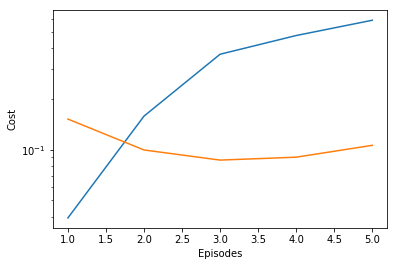

In [14]:
'''
Start of training phase
'''

actor_loss_of_episode = []
critic_loss_of_episode = []
Q_predictions_3 = []
Q_predictions_minus_3 = []
Q_predictions_0 = []

tf.reset_default_graph()
with tf.Session() as sess:
    agent = DDPGAgent(mdp.size, action_size_DDPG, lower_bound, upper_bound, sess)
    # agent.load(string) possibility to load a trained model
    for e in range(EPISODES):
        # We initialize the incidence and wind randomly
        WH = w.generateWind()
        hdg0_rand = random.sample(hdg0_rand_vec, 1)[0]
        hdg0 = hdg0_rand * TORAD * np.ones(10)
        
        #  We reinitialize the memory of the flow
        state = mdp.initializeMDP(hdg0, WH)
        mdp.simulator.hyst.reset()
        actor_loss_sim_list = []
        critic_loss_sim_list = []

        for time in range(80):
            # print(time)
            WH = np.random.uniform(mean - std, mean + std, size=wind_samples)
            action = agent.act_epsilon_greedy(state)
            print("the last seen (i,v) is: {}".format((state[0,59]/TORAD,state[1,59])))
            print("the action is: {}".format(action))
            
            # We count luff and bear-off actions
            if action <= 0:
                count_luff+=1
            elif action > 0:
                count_bear_off+=1
            next_state, reward = mdp.transition(action, WH)
            # Reward shaping
            if state[0,59]>19*TORAD:
                reward= reward-0.5
            print("the reward is: {}".format(reward))
            agent.remember(state, action, reward, next_state)

            # For Critic visualization during learning
            # print("Q value for -3,0,3 in current state: {},{},{}".format(agent.evaluate(state,-2.99),agent.evaluate(state,0),agent.evaluate(state,2.99)))

            state = next_state
        if len(agent.memory) >= batch_size:
            a_loss, c_loss = agent.replay(batch_size)
            actor_loss_sim_list.append(a_loss)
            critic_loss_sim_list.append(c_loss)
            print("Actor network loss: {}".format(a_loss))
            print("Critic network loss: {}".format(c_loss))

        # We apply decay on epsilon greedy actions (see contructor of DDPGAgent)
        agent.noise_decay(e)

        # We save CNN weights every 5000 epochs for example
        if e % 5000 == 0 and e != 0:
            agent.save("../Networks/DDPG/Your_Network_Name"+ str(e) +"_epochs")

        # Critic evaluation every epoch
        Q_predictions_3.append(list(agent.evaluate(state, 3.0))[0])
        Q_predictions_minus_3.append(list(agent.evaluate(state, -3.0))[0])
        Q_predictions_0.append(list(agent.evaluate(state, 0))[0])

        actor_loss_over_simulation_time = np.sum(np.array([actor_loss_sim_list])) / len(np.array([actor_loss_sim_list]))
        actor_loss_of_episode.append(actor_loss_over_simulation_time)
        critic_loss_over_simulation_time = np.sum(np.array([critic_loss_sim_list])) / len(np.array([critic_loss_sim_list]))
        critic_loss_of_episode.append(critic_loss_over_simulation_time)
        print("episode: {}/{}, Actor Mean Loss = {}"
              .format(e, EPISODES, actor_loss_over_simulation_time))
        print("episode: {}/{}, Critic Mean Loss = {}"
              .format(e, EPISODES, critic_loss_over_simulation_time))

    # Save final tensorflow session
    agent.save("../Networks/DDPG/ddpg-test")

# Save test elements
comment = "ddpg-test"
# np.save("../Networks/DDPG/actor_loss_"+comment,np.array(actor_loss_of_episode))
# np.save("../Networks/DDPG/critic_loss_"+comment,np.array(critic_loss_of_episode))
# np.save("../Networks/DDPG/Q3_"+comment, np.array(Q_predictions_3))
# np.save("../Networks/DDPG/Qminus3_"+comment, np.array(Q_predictions_minus_3))
# np.save("../Networks/DDPG/Q0_"+comment, np.array(Q_predictions_0))

print("n_luff : {}".format(count_luff))
print("n_bear_off : {}".format(count_bear_off))

plt.semilogy(np.linspace(1, EPISODES, EPISODES), np.array(actor_loss_of_episode))
plt.xlabel("Episodes")
plt.ylabel("Cost")
plt.semilogy(np.linspace(1, EPISODES, EPISODES), np.array(critic_loss_of_episode))
plt.xlabel("Episodes")
plt.ylabel("Cost")
plt.show()



Once a **DDPGAgent** is trained, it is possible to visualize simulations in module **DDPGVisualization**. 
A lot of options are included in this module, like visualizing the Q-greedy policy of DDPG (to analyse critic convergence and actor separately), of simulate wind gusts to simulate higher level of sailing.

INFO:tensorflow:Restoring parameters from ../Networks/DDPG/ddpg-test.ckpt
[ 0.08441091]
[ 0.10313225]
[ 0.17200851]
[ 0.24382353]
[ 0.29966855]
[ 0.33707905]
[ 0.35611057]
[ 0.36414003]
[ 0.37349153]
[ 0.38369846]
[ 0.39442921]
[ 0.40534043]
[ 0.41609764]
[ 0.42647266]
[ 0.43662739]
[ 0.44661283]
[ 0.45631361]
[ 0.46590114]
[ 0.47532463]
[ 0.48453999]
[ 0.49346066]
[ 0.50173545]
[ 0.50922203]
[ 0.51597404]
[ 0.52215815]
[ 0.52774501]
[ 0.53233409]
[ 0.53588772]
[ 0.53072906]
[ 0.50838566]
[ 0.48033285]
[ 0.45158052]
[ 0.42982912]
[ 0.4182322]
[ 0.41479445]
[ 0.41665077]
[ 0.41828442]
[ 0.41978359]
[ 0.42130899]
[ 0.42298222]
[ 0.42482615]
[ 0.42680073]
[ 0.42884064]
[ 0.43087292]
[ 0.43274474]
[ 0.4343586]
[ 0.43586445]
[ 0.43720365]
[ 0.43851185]
[ 0.43981457]
[ 0.44088507]
[ 0.44178677]
[ 0.44219875]
[ 0.44194865]
[ 0.44128609]
[ 0.44029927]
[ 0.43942261]
[ 0.4390204]
[ 0.43916774]
[ 0.43549919]
[ 0.43111825]
[ 0.425138]
[ 0.42041516]
[ 0.4170785]
[ 0.4151597]
[ 0.4151597]
[ 0.415159

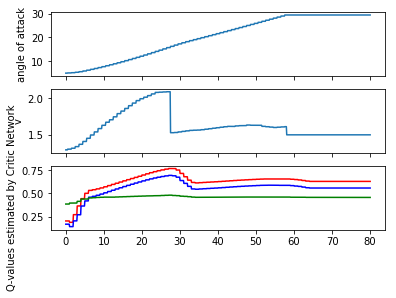

-3
-3
-3
-3
-3
-3
-3
-3
-3
-3
-3
-3
-3
-3
-3
-3
-3
-3
-3
-3
-3
-3
-3
-3
-3
-3
-3
-3
-3
-3
-3
-3
-3
-3
-3
-3
-3
-3
-3
-3
-3
-3
-3
-3
-3
-3
-3
-3
-3
-3
-3
-3
-3
-3
-3
-3
-3
-3
-3
-3
-3
-3
-3
-3
-3
-3
-3
-3
-3
-3
-3
-3
-3
-3
-3
-3
-3
-3
-3
-3


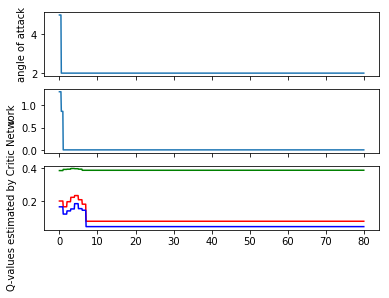

[ 0.10644865]
[ 0.12979889]
[ 0.22108889]
[ 0.31126213]
[ 0.38174248]
[ 0.42472792]
[ 0.44267178]
[ 0.44243431]
[ 0.44183111]
[ 0.44095087]
[ 0.43995023]
[ 0.43920708]
[ 0.43893433]
[ 0.43498707]
[ 0.43050003]
[ 0.42458487]
[ 0.41996336]
[ 0.4167552]
[ 0.41492033]
[ 0.41492033]
[ 0.41492033]
[ 0.41492033]
[ 0.41492033]
[ 0.41492033]
[ 0.41492033]
[ 0.41492033]
[ 0.41492033]
[ 0.41492033]
[ 0.41492033]
[ 0.41492033]
[ 0.41492033]
[ 0.41492033]
[ 0.41492033]
[ 0.41492033]
[ 0.41492033]
[ 0.41492033]
[ 0.41492033]
[ 0.41492033]
[ 0.41492033]
[ 0.41492033]
[ 0.41492033]
[ 0.41492033]
[ 0.41492033]
[ 0.41492033]
[ 0.41492033]
[ 0.41492033]
[ 0.41492033]
[ 0.41492033]
[ 0.41492033]
[ 0.41492033]
[ 0.41492033]
[ 0.41492033]
[ 0.41492033]
[ 0.41492033]
[ 0.41492033]
[ 0.41492033]
[ 0.41492033]
[ 0.41492033]
[ 0.41492033]
[ 0.41492033]
[ 0.41492033]
[ 0.41492033]
[ 0.41492033]
[ 0.41492033]
[ 0.41492033]
[ 0.41492033]
[ 0.41492033]
[ 0.41492033]
[ 0.41492033]
[ 0.41492033]
[ 0.41492033]
[ 0.414

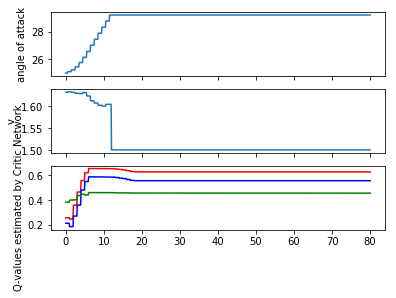

-3
-3
-3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3


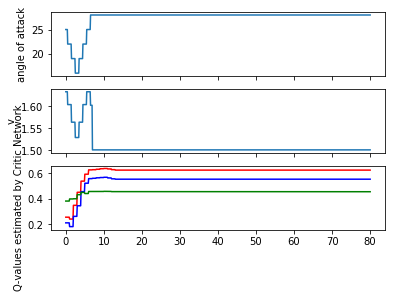

In [15]:
from DDPGvisualization import DDPGVisualization
tf.reset_default_graph()
v = DDPGVisualization(6, 1, 0.1, 1, -3.0, 3.0, 45 * TORAD, 0 * TORAD, 0, "../Networks/DDPG/ddpg-test",80)
f1 = v.simulateDDPGControl(0)
f1c = v.simulateDDPGCritic(0)
f2 = v.simulateDDPGControl(20)
f2c = v.simulateDDPGCritic(20)